---
title: Introduction to Transformers
author: Mark Fuge
date: November 25, 2025
format:
    html:
        code-fold: true
        code-summary: "Show Code"
---

In prior chapters we explored various push-forward generative models as well as flow-based models. We have not yet addressed auto-regressive models, which are a third major class of generative models. Auto-regressive models are based on the idea of factorizing the joint distribution of data into a product of conditional distributions. There are many such models, including RNNs, LSTMs, and GRUs. However, in recent years, a new architecture called the *Transformer* has revolutionized the field of natural language processing (NLP) and has also been successfully applied to other domains such as computer vision and audio processing. This chapter introduces the Transformer architecture, its key components, and builds intuition behind how it works using simple 2D examples.

## Learning Objectives
- Connect geometric intuition (shapes and point clouds) to transformer mechanics such as self-attention and global pooling.
- Compare MLPs, PointNet-style models, and transformers on fixed vs. variable set classification problems.
- Practice building PyTorch training loops, visualization helpers, and attention diagnostics that generalize across datasets.

In [1]:
import math
import random
from typing import Callable, Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset, random_split

# Optional Plotly import for interactive 3D visualization
try:
    import plotly.graph_objs as go
    from plotly.offline import init_notebook_mode
    init_notebook_mode(connected=True)
    PLOTLY_AVAILABLE = True
except Exception:
    PLOTLY_AVAILABLE = False

plt.style.use("seaborn-v0_8")
torch.set_float32_matmul_precision("high")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

def to_device(batch: Dict[str, torch.Tensor], device: torch.device) -> Dict[str, torch.Tensor]:
    return {k: v.to(device) if torch.is_tensor(v) else v for k, v in batch.items()}

In [2]:
def default_forward(model: nn.Module, batch: Dict[str, torch.Tensor], device: torch.device) -> torch.Tensor:
    return model(batch["inputs"].to(device))

def train_classifier(
    model: nn.Module,
    train_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
    epochs: int,
    *,
    device: torch.device = DEVICE,
    forward_fn: Optional[Callable[[nn.Module, Dict[str, torch.Tensor], torch.device], torch.Tensor]] = None,
    val_loader: Optional[DataLoader] = None,
) -> Dict[str, List[float]]:
    history: Dict[str, List[float]] = {"train_loss": [], "train_acc": []}
    if val_loader is not None:
        history.update({"val_loss": [], "val_acc": []})

    forward = forward_fn or default_forward
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0
        running_total = 0

        for batch in train_loader:
            optimizer.zero_grad()
            logits = forward(model, batch, device)
            if isinstance(logits, tuple):
                logits = logits[0]
            labels = batch["labels"].to(device)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            preds = torch.argmax(logits, dim=-1)
            running_correct += (preds == labels).sum().item()
            running_total += labels.size(0)

        history["train_loss"].append(running_loss / running_total)
        history["train_acc"].append(running_correct / running_total)

        if val_loader is not None:
            val_metrics = evaluate_classifier(model, val_loader, criterion, forward_fn=forward, device=device)
            history["val_loss"].append(val_metrics["loss"])
            history["val_acc"].append(val_metrics["acc"])

        print(
            f"Epoch {epoch + 1:02d}/{epochs} | "
            f"train_loss={history['train_loss'][-1]:.4f} train_acc={history['train_acc'][-1]:.3f}"
            + (
                f" | val_loss={history['val_loss'][-1]:.4f} val_acc={history['val_acc'][-1]:.3f}" if val_loader is not None else ""
            )
        )

    return history

def evaluate_classifier(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: Optional[Callable[[torch.Tensor, torch.Tensor], torch.Tensor]] = None,
    *,
    device: torch.device = DEVICE,
    forward_fn: Optional[Callable[[nn.Module, Dict[str, torch.Tensor], torch.device], torch.Tensor]] = None,
) -> Dict[str, np.ndarray]:
    forward = forward_fn or default_forward
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    preds_list: List[torch.Tensor] = []
    labels_list: List[torch.Tensor] = []

    with torch.no_grad():
        for batch in data_loader:
            logits = forward(model, batch, device)
            if isinstance(logits, tuple):
                logits = logits[0]
            labels = batch["labels"].to(device)
            if criterion is not None:
                loss = criterion(logits, labels)
                total_loss += loss.item() * labels.size(0)
            predictions = torch.argmax(logits, dim=-1)
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)
            preds_list.append(predictions.cpu())
            labels_list.append(labels.cpu())

    preds_tensor = torch.cat(preds_list)
    labels_tensor = torch.cat(labels_list)
    metrics = {
        "loss": (total_loss / total_samples) if criterion is not None else math.nan,
        "acc": total_correct / total_samples,
        "preds": preds_tensor.numpy(),
        "labels": labels_tensor.numpy(),
    }
    return metrics

In [90]:
def plot_history(history: Dict[str, List[float]], title: str) -> None:
    if not history:
        return
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(history["train_loss"], label="train")
    if "val_loss" in history:
        axes[0].plot(history["val_loss"], label="val")
    axes[0].set_title(f"Loss | {title}")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Cross-Entropy")
    axes[0].legend()

    axes[1].plot(history["train_acc"], label="train")
    if "val_acc" in history:
        axes[1].plot(history["val_acc"], label="val")
    axes[1].set_title(f"Accuracy | {title}")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_ylim(0, 1.05)
    axes[1].legend()
    plt.tight_layout()


def plot_confusion(cm: np.ndarray, class_names: List[str], title: str) -> None:
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()


def scatter_2d_points(points: np.ndarray, label: str, ax: Optional[plt.Axes] = None, colors: Optional[np.ndarray] = None) -> None:
    if ax is None:
        ax = plt.gca()
    if colors is None:
        ax.scatter(points[:, 0], points[:, 1], s=10, alpha=0.8)
    else:
        sc = ax.scatter(points[:, 0], points[:, 1], c=colors, cmap="viridis", s=10)
        plt.colorbar(sc, ax=ax, fraction=0.046)
    ax.set_aspect("equal")
    ax.set_title(label)


def scatter_3d_points(points: np.ndarray, label: str, colors: Optional[np.ndarray] = None, interactive: bool = False) -> None:
    """3D scatter with optional interactive Plotly backend.

    Parameters
    ----------
    points : (N,3) array
        Point coordinates.
    label : str
        Title for the plot.
    colors : (N,) array, optional
        Scalar weights for coloring points.
    interactive : bool
        If True and Plotly is available, render interactive plot; else fallback to Matplotlib.
    """
    if interactive and PLOTLY_AVAILABLE:
        if colors is None:
            colors = np.zeros(points.shape[0])
        trace = go.Scatter3d(
            x=points[:, 0],
            y=points[:, 1],
            z=points[:, 2],
            mode="markers",
            marker=dict(size=2, color=colors, colorscale="Viridis", opacity=0.8),
        )
        layout = go.Layout(title=label, scene=dict(xaxis_title="x", yaxis_title="y", zaxis_title="z"), height=500)
        fig = go.Figure(data=[trace], layout=layout)
        fig.show()
    else:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.add_subplot(111, projection="3d")
        if colors is None:
            ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=5, alpha=0.8)
        else:
            sc = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors, cmap="inferno", s=8)
            fig.colorbar(sc, ax=ax, shrink=0.6)
        ax.set_title(label)
        plt.tight_layout()


def plot_metric_curve(df: pd.DataFrame, title: str, hue: str = "model") -> None:
    plt.figure(figsize=(6, 4))
    sns.lineplot(data=df, x="noise", y="accuracy", hue=hue, marker="o")
    plt.title(title)
    plt.ylabel("Accuracy")
    plt.xlabel("Noise std")
    plt.ylim(0, 1.05)
    plt.tight_layout()

def plot_attention_overlay(points: np.ndarray, weights: np.ndarray, title: str) -> None:
    norm_weights = (weights - weights.min()) / (weights.max() - weights.min() + 1e-8)
    scatter_2d_points(points, title, colors=norm_weights)

def visualize_embeddings(embeddings: np.ndarray, labels: np.ndarray, class_names: List[str], title: str, method: str = "pca", dim=2) -> None:
    reducer = PCA(n_components=dim) if method.lower() == "pca" else TSNE(n_components=dim, perplexity=30, learning_rate="auto")
    reduced = reducer.fit_transform(embeddings)
    # If dim == 3, use plotly for interactive plot if available
    if dim == 3 and PLOTLY_AVAILABLE:
        # Create separate traces for each class to get proper legend
        traces = []
        unique_labels = np.unique(labels)
        for label_idx in unique_labels:
            mask = labels == label_idx
            trace = go.Scatter3d(
                x=reduced[mask, 0],
                y=reduced[mask, 1],
                z=reduced[mask, 2],
                mode="markers",
                name=class_names[label_idx],
                marker=dict(size=3, opacity=0.7),
            )
            traces.append(trace)
        layout = go.Layout(
            title=f"{title} ({method.upper()})",
            scene=dict(xaxis_title="Component 1", yaxis_title="Component 2", zaxis_title="Component 3"),
            height=600,
            showlegend=True,
        )
        fig = go.Figure(data=traces, layout=layout)
        fig.show()
        return
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=[class_names[i] for i in labels], s=15, palette="deep", alpha=0.8)
    plt.title(f"{title} ({method.upper()})")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()

## Example: 2D Shapes — Fixed-Size Set Classification
To build intuition, we will start with a simple classification problem: given a set of 2D points sampled from a shape, classify which shape it is. We will start with the simplest model we could imagine for this task and then later show how this breaks down. Specifically, for a fixed-size input set of $n$ points in 2D, we can flatten the input and feed it into a standard MLP classifier, as we show below. First, let's visualize some example data and labels:

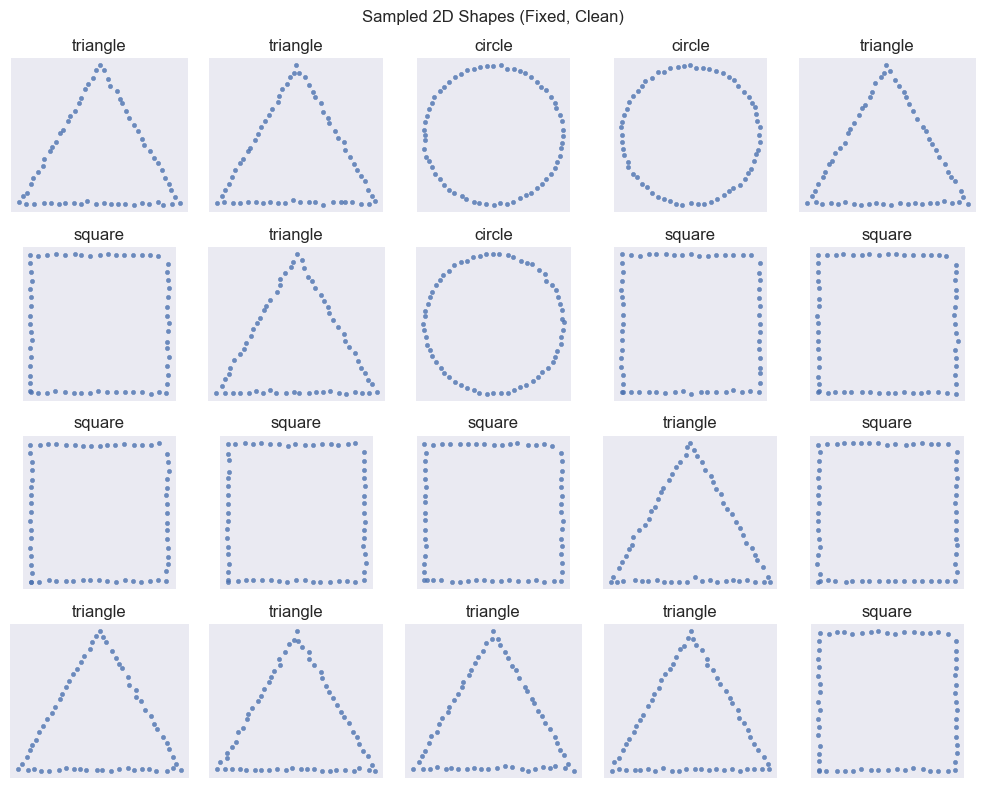

In [16]:
SHAPE_TYPES = ["circle", "square", "triangle"]

def generate_2d_shape(shape_type: str, n_points: int = 64, noise: float = 0.0, randomize: bool = False) -> np.ndarray:
    """Generate a 2D shape as a set of points with EXACT length n_points.

    Ensures fixed-size output so downstream stacking does not fail.
    If a deterministic construction produces fewer points (e.g. triangle edges),
    we upsample by randomly repeating existing points (optionally with tiny jitter).
    """
    if shape_type not in SHAPE_TYPES:
        raise ValueError(f"Unknown shape: {shape_type}")

    if shape_type == "circle":
        angles = np.linspace(0, 2 * np.pi, n_points, endpoint=False) if not randomize else np.random.rand(n_points) * 2 * np.pi
        x = np.cos(angles)
        y = np.sin(angles)
        points = np.stack([x, y], axis=1)

    elif shape_type == "square":
        if not randomize:
            # Distribute points roughly evenly across four edges
            base = n_points // 4
            rem = n_points % 4
            counts = [base + (i < rem) for i in range(4)]  # allocate remainder
            edges_vals = [
                np.linspace(-1, 1, c, endpoint=False) if c > 0 else np.array([]) for c in counts
            ]
            # Right, Left, Top, Bottom (avoid duplicating corners due to endpoint=False)
            points = np.concatenate(
                [
                    np.stack([np.ones(len(edges_vals[0])), edges_vals[0]], axis=1),
                    np.stack([-np.ones(len(edges_vals[1])), edges_vals[1]], axis=1),
                    np.stack([edges_vals[2], np.ones(len(edges_vals[2]))], axis=1),
                    np.stack([edges_vals[3], -np.ones(len(edges_vals[3]))], axis=1),
                ],
                axis=0,
            )
        else:
            choices = np.random.choice(4, size=n_points)
            t = np.random.uniform(-1, 1, size=n_points)
            points = np.zeros((n_points, 2))
            points[choices == 0] = np.stack([np.ones(np.sum(choices == 0)), t[choices == 0]], axis=1)
            points[choices == 1] = np.stack([-np.ones(np.sum(choices == 1)), t[choices == 1]], axis=1)
            points[choices == 2] = np.stack([t[choices == 2], np.ones(np.sum(choices == 2))], axis=1)
            points[choices == 3] = np.stack([t[choices == 3], -np.ones(np.sum(choices == 3))], axis=1)

    else:  # triangle
        vertices = np.array([[0, 1], [-math.sqrt(3) / 2, -0.5], [math.sqrt(3) / 2, -0.5]])
        if not randomize:
            base = n_points // 3
            rem = n_points % 3
            counts = [base + (i < rem) for i in range(3)]
            edges = []
            for i in range(3):
                start = vertices[i]
                end = vertices[(i + 1) % 3]
                c = counts[i]
                if c > 0:
                    edge = np.linspace(start, end, c, endpoint=False)
                    edges.append(edge)
            points = np.concatenate(edges, axis=0)
        else:
            # Uniform sampling along the edges of each length of the triangle
            choices = np.random.choice(3, size=n_points)
            t = np.random.uniform(0, 1, size=n_points)
            points = np.zeros((n_points, 2))
            for i in range(3):
                start = vertices[i]
                end = vertices[(i + 1) % 3]
                mask = choices == i
                points[mask] = np.outer(1 - t[mask], start) + np.outer(t[mask], end)

    # Enforce exact length in case construction mismatch (safety net)
    current = points.shape[0]
    if current < n_points:
        extra_idx = np.random.choice(current, n_points - current, replace=True)
        extra = points[extra_idx] + np.random.normal(scale=noise * 0.1, size=(n_points - current, points.shape[1]))
        points = np.concatenate([points, extra], axis=0)
    elif current > n_points:
        points = points[:n_points]

    if randomize:
        perm = np.random.permutation(points.shape[0])
        points = points[perm]

    points += np.random.normal(scale=noise, size=points.shape)
    return points[:n_points]


def make_fixed_shape_dataset(num_samples: int = 10000, n_points: int = 64, noise: float = 0.01) -> Tuple[torch.Tensor, torch.Tensor]:
    samples = []
    labels = []
    for _ in range(num_samples):
        label = random.randrange(len(SHAPE_TYPES))
        pts = generate_2d_shape(SHAPE_TYPES[label], n_points=n_points, noise=noise, randomize=False)
        samples.append(pts)
        labels.append(label)
    data = torch.tensor(np.stack(samples), dtype=torch.float32)
    targets = torch.tensor(labels, dtype=torch.long)
    return data, targets


class FixedShapeDataset(Dataset):
    def __init__(self, data: torch.Tensor, labels: torch.Tensor):
        self.points = data
        self.labels = labels
        self.inputs = data.reshape(data.size(0), -1)

    def __len__(self) -> int:
        return self.labels.size(0)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        return {
            "points": self.points[idx],
            "inputs": self.inputs[idx],
            "labels": self.labels[idx],
        }


def dict_collate(batch: List[Dict[str, torch.Tensor]]) -> Dict[str, torch.Tensor]:
    keys = batch[0].keys()
    collated = {}
    for key in keys:
        collated[key] = torch.stack([item[key] for item in batch], dim=0)
    return collated

fixed_points, fixed_labels = make_fixed_shape_dataset(num_samples=10000, n_points=64, noise=0.01)
fixed_dataset = FixedShapeDataset(fixed_points, fixed_labels)
train_ds, val_ds = random_split(
    fixed_dataset,
    [int(0.8 * len(fixed_dataset)), len(fixed_dataset) - int(0.8 * len(fixed_dataset))],
)

batch_size = 256
train_loader_fixed = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=dict_collate)
val_loader_fixed = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=dict_collate)

fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for ax, idx in zip(axes.ravel(), np.random.choice(len(fixed_dataset), size=20, replace=False)):
    sample = fixed_dataset[idx]
    scatter_2d_points(sample["points"].numpy(), SHAPE_TYPES[sample["labels"].item()], ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
plt.suptitle("Sampled 2D Shapes (Fixed, Clean)")
plt.tight_layout()

As we can see, the dataset consists of points sampled from three different shapes: circles, squares, and triangles. Each shape is represented by a set of 2D points of a fixed length, and our goal is to classify the shape based on these points. For this, let's build a simple MLP classifier that takes the flattened set of points as input and outputs the predicted shape class:

In [17]:
#| code-fold: false
class ShapeMLP(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: Tuple[int, ...] = (256, 128, 64), num_classes: int = 3, dropout: float = 0.1):
        super().__init__()
        layers: List[nn.Module] = []
        dims = [input_dim, *hidden_dims]
        for in_dim, out_dim in zip(dims[:-1], dims[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        self.feature_extractor = nn.Sequential(*layers)
        self.classifier = nn.Linear(hidden_dims[-1], num_classes)

    def forward(self, x: torch.Tensor, return_features: bool = False):
        features = self.feature_extractor(x)
        logits = self.classifier(features)
        if return_features:
            return logits, features
        return logits

# Now train the MLP on the fixed-size shape dataset
mlp_fixed = ShapeMLP(input_dim=64 * 2, hidden_dims=(256, 128, 64), num_classes=len(SHAPE_TYPES))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(mlp_fixed.parameters(), lr=1e-3, weight_decay=1e-4)

def mlp_forward(model, batch, device):
    return model(batch["inputs"].to(device))

history_fixed = train_classifier(
    mlp_fixed,
    train_loader_fixed,
    optimizer,
    criterion,
    epochs=3,
    forward_fn=mlp_forward,
    val_loader=val_loader_fixed,
)

Epoch 01/3 | train_loss=0.3110 train_acc=0.960 | val_loss=0.0000 val_acc=1.000
Epoch 02/3 | train_loss=0.0000 train_acc=1.000 | val_loss=0.0000 val_acc=1.000
Epoch 03/3 | train_loss=0.0000 train_acc=1.000 | val_loss=0.0000 val_acc=1.000


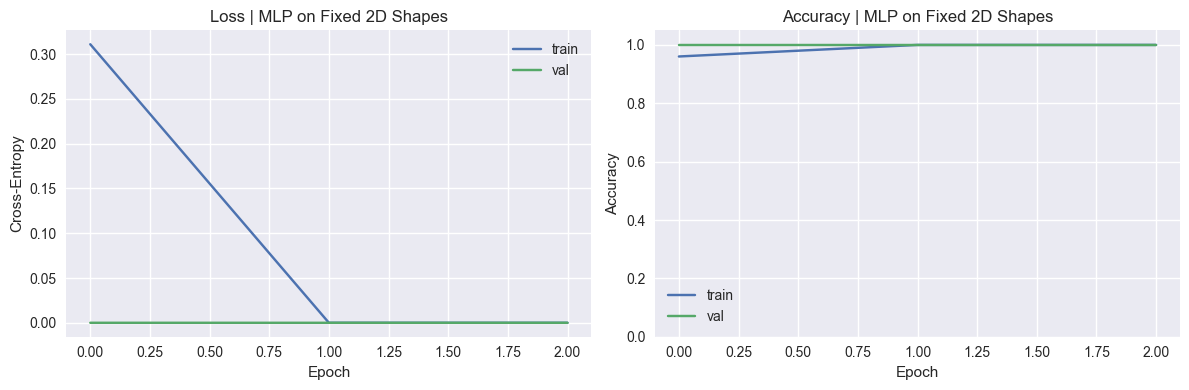

In [18]:
plot_history(history_fixed, "MLP on Fixed 2D Shapes")

Validation accuracy: 100.00%


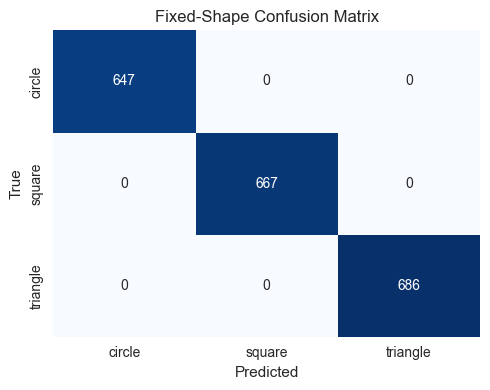

In [19]:
eval_fixed = evaluate_classifier(mlp_fixed, val_loader_fixed, criterion, forward_fn=mlp_forward)
cm_fixed = confusion_matrix(eval_fixed["labels"], eval_fixed["preds"])
plot_confusion(cm_fixed, SHAPE_TYPES, "Fixed-Shape Confusion Matrix")
print(f"Validation accuracy: {eval_fixed['acc'] * 100:.2f}%")

As we can see from the results above, the MLP does a great job on this particular task, achieving high accuracy on the test set. However, one reason for this is that every shape (1) had the same number of points and (2) the points were always presented in the same order. What happens to the MLP if we change these assumptions? Let's explore this next by permuting the order of the points in each set.

## 2D Shapes — Variable-Length Sets with Noise and Shuffling
In reality, we cannot always guarantee that our input sets will have a fixed size or that the points will be presented in a consistent order. For example, if the points we receive come from a 3D scanner or automated unstructured meshing algorithm. To simulate this on our toy example, we will modify our dataset by randomizing the number of points sampled from each shape, including the order, and adding some jitter to the point locations to simulate measurement noise. Let's see how the MLP does in this case. We keep the same MLP architecture but because we do not know the number of points in advance, we are now forced to pad every set to the maximum possible length so the linear layers see a fixed-size vector.

In [24]:
class VariableShapeDataset(Dataset):
    def __init__(self, num_samples: int = 4000, length_range: Tuple[int, int] = (20, 200), noise_std: float = 0.05):
        self.samples: List[torch.Tensor] = []
        self.labels: List[int] = []
        self.length_range = length_range
        self.max_points = length_range[1]
        for _ in range(num_samples):
            label = random.randrange(len(SHAPE_TYPES))
            n_points = random.randint(length_range[0], length_range[1])
            pts = generate_2d_shape(SHAPE_TYPES[label], n_points=n_points, noise=noise_std, randomize=True)
            self.samples.append(torch.tensor(pts, dtype=torch.float32))
            self.labels.append(label)

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        points = self.samples[idx]
        return {
            "points": points,
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
            "length": torch.tensor(points.size(0), dtype=torch.long),
        }


def build_variable_collate(max_points: int, feature_dim: int = 2):
    def collate(batch: List[Dict[str, torch.Tensor]]) -> Dict[str, torch.Tensor]:
        batch_size = len(batch)
        padded = torch.zeros(batch_size, max_points, feature_dim)
        mask = torch.ones(batch_size, max_points, dtype=torch.bool)
        labels = torch.zeros(batch_size, dtype=torch.long)
        for i, item in enumerate(batch):
            n = min(item["points"].size(0), max_points)
            padded[i, :n] = item["points"][:n]
            mask[i, :n] = False
            labels[i] = item["labels"]
        flat = padded.reshape(batch_size, -1)
        return {"points": padded, "mask": mask, "inputs": flat, "labels": labels}

    return collate

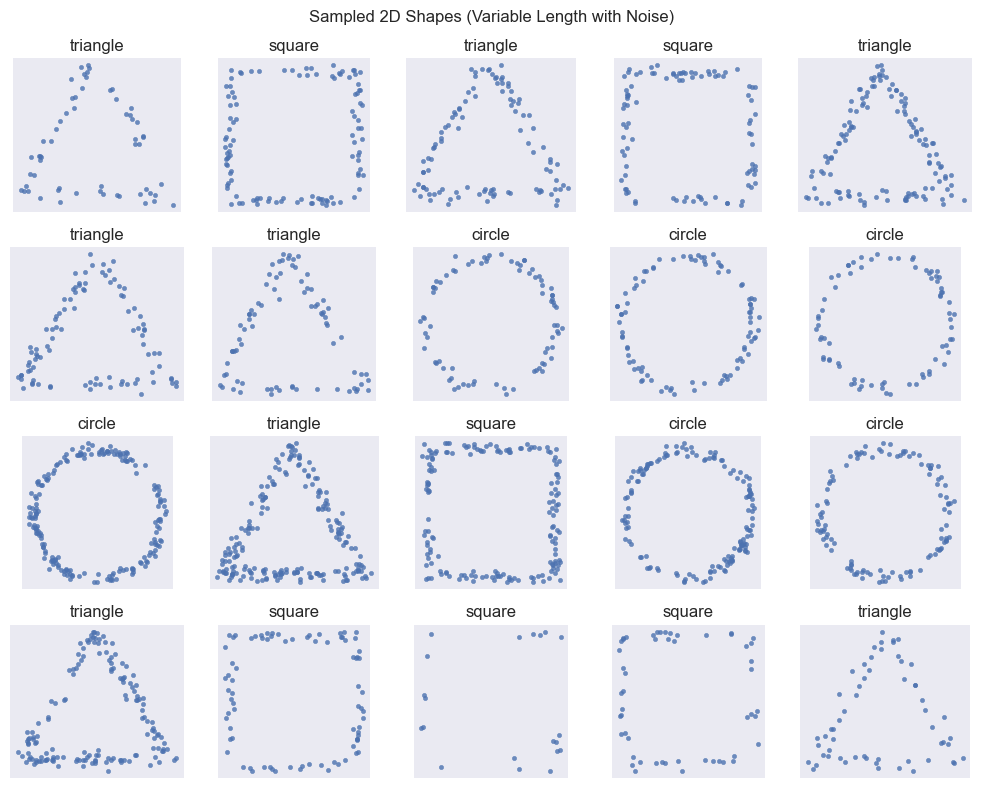

In [25]:
# Visualize some variable-length shapes
var_dataset = VariableShapeDataset(num_samples=20, length_range=(20, 200), noise_std=0.05)
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for ax, idx in zip(axes.ravel(), range(len(var_dataset))):
    sample = var_dataset[idx]
    scatter_2d_points(sample["points"].numpy(), SHAPE_TYPES[sample["labels"].item()], ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
plt.suptitle("Sampled 2D Shapes (Variable Length with Noise)")
plt.tight_layout()
plt.show()

Epoch 01/10 | train_loss=1.0766 train_acc=0.351 | val_loss=1.0515 val_acc=0.373
Epoch 02/10 | train_loss=0.9691 train_acc=0.520 | val_loss=1.0408 val_acc=0.437
Epoch 03/10 | train_loss=0.7116 train_acc=0.697 | val_loss=1.0556 val_acc=0.502
Epoch 04/10 | train_loss=0.3864 train_acc=0.847 | val_loss=1.1267 val_acc=0.540
Epoch 05/10 | train_loss=0.2029 train_acc=0.933 | val_loss=1.3843 val_acc=0.553
Epoch 06/10 | train_loss=0.1280 train_acc=0.955 | val_loss=1.6696 val_acc=0.537
Epoch 07/10 | train_loss=0.0800 train_acc=0.975 | val_loss=1.7424 val_acc=0.551
Epoch 08/10 | train_loss=0.0627 train_acc=0.978 | val_loss=2.1464 val_acc=0.517
Epoch 09/10 | train_loss=0.0548 train_acc=0.982 | val_loss=2.1447 val_acc=0.551
Epoch 10/10 | train_loss=0.0493 train_acc=0.983 | val_loss=2.2817 val_acc=0.553
Noise 0.01 | MLP accuracy: 55.3%
Epoch 01/10 | train_loss=1.0808 train_acc=0.358 | val_loss=1.0528 val_acc=0.368
Epoch 02/10 | train_loss=1.0001 train_acc=0.472 | val_loss=1.0448 val_acc=0.436
Epoch 0

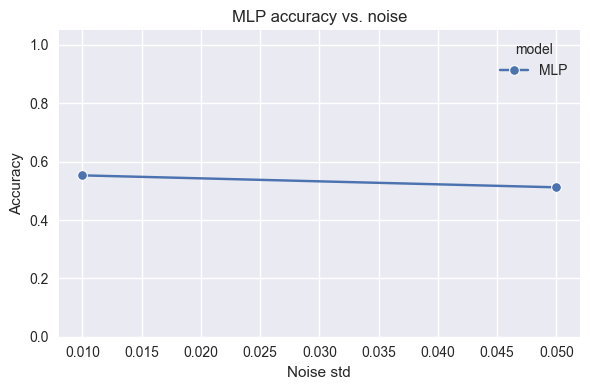

In [26]:
#| code-fold: false`
noise_levels = [0.01, 0.05]#, 0.1, 0.2]
mlp_variable_results = []

for noise in noise_levels:
    dataset = VariableShapeDataset(num_samples=5000, length_range=(20, 200), noise_std=noise)
    collate_fn = build_variable_collate(dataset.max_points, feature_dim=2)
    train_ds, val_ds = random_split(
        dataset,
        [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))],
    )
    train_loader = DataLoader(train_ds, batch_size=192, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_ds, batch_size=256, shuffle=False, collate_fn=collate_fn)

    mlp = ShapeMLP(input_dim=dataset.max_points * 2, hidden_dims=(512, 256, 128), num_classes=len(SHAPE_TYPES))
    optimizer = torch.optim.AdamW(mlp.parameters(), lr=1e-3, weight_decay=5e-4)
    history = train_classifier(
        mlp,
        train_loader,
        optimizer,
        criterion,
        epochs=10,
        forward_fn=mlp_forward,
        val_loader=val_loader,
    )
    metrics = evaluate_classifier(mlp, val_loader, criterion, forward_fn=mlp_forward)
    mlp_variable_results.append({"model": "MLP", "noise": noise, "accuracy": metrics["acc"]})
    print(f"Noise {noise:.2f} | MLP accuracy: {metrics['acc'] * 100:.1f}%")

mlp_variable_df = pd.DataFrame(mlp_variable_results)
plot_metric_curve(mlp_variable_df, "MLP accuracy vs. noise")

We see now that unlike before, the MLP's performance degrades significantly as we introduce variability in the input sets. This is because the MLP relies on a consistent ordering and number of points to learn meaningful patterns, and when these assumptions are violated, it struggles to generalize. We can fix this by instead operating on *sets* of unordered points rather than flattened vectors where we assume that everything is consistently ordered. To enable this, we will use a transformer architecture that can handle variable-length sets and is invariant to the order of the points.

## What Is a Transformer?

At a high level, a transformer is a **function on sets or sequences of vectors** that learns _how much each element should pay attention to every other element_ when computing a new representation.



Given an input set (or sequence)

$$X = [x_1, x_2, \dots, x_n], \qquad x_i \in \mathbb{R}^d,$$

a single **self-attention layer** produces new vectors $z_i$:

$$Z = [z_1, z_2, \dots, z_n], \qquad z_i \in \mathbb{R}^{d_{\text{model}}}.$$



It involves three key steps:

1. **Linear projections** (learned):

   $$q_i = W_Q x_i, \quad k_i = W_K x_i, \quad v_i = W_V x_i,$$

   where $W_Q, W_K, W_V$ are matrices.

2. **Attention weights** from pairwise similarity of queries and keys:

   $$a_{ij} = \text{softmax}_j\left(\frac{q_i^\top k_j}{\sqrt{d_k}}\right),$$

   which say how much point $i$ listens to point $j$. The division by $\sqrt{d_k}$ is a scaling factor that helps with training stability since the dot products can grow large in magnitude as the dimension $d_k$ increases, and thus push the softmax into regions with very small gradients, so the square root helps normalize the variance of the dot products. The softmax ensures the weights sum to 1 across $j$ for each fixed $i$.[^1]

3. **Weighted aggregation of values**:

   $$z_i = \sum_{j=1}^n a_{ij} v_j.$$

   which produces the new representation for point $i$.


Typically, multiple attention heads are run in parallel (with different $W_Q, W_K, W_V$) and their outputs are concatenated and mixed with a small MLP. Stacking these layers produces a network that can attend globally to the whole set with content-dependent weights, unlike convolutions which can only attend across a short window.

For transformers in general, there is a rich set of possible variants and add-ons that one can include or study, but for this chapter we will keep it simple and try to build intuition using only unordered point sets. This means we will not be doing certain common operations in transformers like adding positional encoders or similar.

[^1]: The softmax function is defined as follows: for a vector $z \in \mathbb{R}^n$, the softmax of $z$ is a vector $\text{softmax}(z) \in \mathbb{R}^n$ where each component is given by $$\text{softmax}(z)_i = \frac{e^{z_i}}{\sum_{j=1}^n e^{z_j}}.$$

### MLPs vs. Transformers on Sets



It is useful to pause and contrast **how** the two architectures see the same data.



**MLP view of a point set**



For the variable-length experiment, we padded each set to a common maximum size $N_\text{max}$ and then _flatten_ all coordinates into a single long vector:

$$x = [p_{1,x}, p_{1,y}, \dots, p_{N_\text{max},x}, p_{N_\text{max},y}]^\top \in \mathbb{R}^{2N_\text{max}}.$$

An $L$-layer MLP implements a composition of affine maps and pointwise nonlinearities

$$f_\text{MLP}(x) = W_L \sigma( W_{L-1} \sigma( \cdots \sigma(W_1 x + b_1) ) + b_{L-1}) + b_L.$$



**Key properties of this representation:**

- Each coordinate position (e.g., "entry 17") has a **fixed semantic meaning** during training.

- If we change the **ordering or count** of points, the mapping from "position index" to "physical location in the shape" is destroyed.

- As a result, the MLP **is not permutation-invariant**: shuffling points changes the prediction in an uncontrolled way.



**Transformer view of the same set**



The transformer instead keeps the set as a matrix

$$X \in \mathbb{R}^{N_\text{max} \times d}, \quad d=2 \text{ for 2D; } X_i = p_i,$$

and produces a new matrix $Z \in \mathbb{R}^{N_\text{max} \times d_\text{model}}$ by self-attention. Classification then uses either

- a special **CLS token** $z_\text{CLS}$, or

- a permutation-invariant pooling (mean or max) over rows of $Z$.



If we mask out padded rows and ignore them in attention, then:

- Reordering the **actual points** corresponds to permuting the rows of $X$.

- Self-attention plus pooling can be made **permutation-invariant** over the true points.


This means that the output of the transformer depends only on the **set** of points, not on their ordering, which is exactly what we need if we cannot rely on a fixed ordering or input sequence. The experiment below shows this numerically: once we break the ordering assumption the transformer will still be able to perform well, where the MLP degraded above.

### Transformer Encoder for Sets
We now treat each point as a token, project $(x, y)$ into a latent space, and apply stacked self-attention blocks with a learned CLS token for global pooling. Padding masks ensure attention ignores fake points. Before we jump into the full transformer encoder, let's first build and train a **tiny single-head self-attention model** on top of simple 2D shapes. The goal is not to get state-of-the-art accuracy, but to have a model whose **entire internal state fits in 2 dimensions and one head** so that we can literally plot:

- the **linear projections** $W_Q, W_K, W_V$ applied to each point,
- the resulting **attention weights** $a_{ij}$ across the set,
- the **aggregated features** $z_i = \sum_j a_{ij} v_j$.

We will first train a very small transformer on a toy classification task (only a few 2D shapes), and then visualize what it has learned.

In [59]:
#| code-fold: false
class MiniSelfAttention(nn.Module):
    """Single-head self-attention with d_model = 2 for visualization.

    This block omits residual connections and feedforward layers on purpose so
    that you can directly see the impact of Q, K, V and the attention
    matrix on a set of 2D points.
    """
    
    def __init__(self, input_dim: int = 2, d_model: int = 2):
        super().__init__()
        self.d_model = d_model
        self.W_q = nn.Linear(input_dim, d_model, bias=False)
        self.W_k = nn.Linear(input_dim, d_model, bias=False)
        self.W_v = nn.Linear(input_dim, d_model, bias=False)

    def forward(self, x: torch.Tensor) -> Dict[str, torch.Tensor]:
        """Compute Q, K, V, attention weights, and output features.

        Parameters
        ----------
        x : (N, 2) tensor
            Input 2D points for a single shape.
        """

        # Compute projections
        Q = self.W_q(x)  # (N, d_model)
        K = self.W_k(x)  # (N, d_model)
        V = self.W_v(x)  # (N, d_model)

        # Scaled dot-product attention logits and weights
        scale = math.sqrt(self.d_model)
        logits = Q @ K.t() / scale  # (N, N)
        A = torch.softmax(logits, dim=-1)  # (N, N)

        # Aggregate values
        Z = A @ V  # (N, d_model)

        return {"Q": Q, "K": K, "V": V, "A": A, "Z": Z}

class SelfAttentionBlock(nn.Module):
    """Batched single-head self-attention block plus optional feedforward.

    This block provides the interface expected by ToySetTransformer:
    - forward(x, key_padding_mask=None) -> (h, attn)
      where x: (B, N, d_model), h: (B, N, d_model), attn: (B, N, N)
    """

    def __init__(self, d_model: int = 2, n_heads: int = 1, dim_feedforward: int = 16, dropout: float = 0.0):
        super().__init__()
        self.d_model = d_model
        # Projections operate on d_model inputs (assumes input already projected to d_model)
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)

        # small position-wise feedforward for demonstration
        self.ff = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, d_model),
            nn.Dropout(dropout),
        )

    def forward(self, x: torch.Tensor, key_padding_mask: Optional[torch.Tensor] = None):
        """Forward pass for batched inputs.

        Parameters
        ----------
        x : (B, N, d_model)
        key_padding_mask : (B, N) boolean mask where True indicates padding positions to ignore
        """
        # Projections
        Q = self.W_q(x)  # (B, N, d)
        K = self.W_k(x)  # (B, N, d)
        V = self.W_v(x)  # (B, N, d)

        # Scaled dot-product attention logits and weights
        scale = math.sqrt(self.d_model)
        logits = torch.matmul(Q, K.transpose(-2, -1)) / scale  # (B, N, N)

        if key_padding_mask is not None:
            # key_padding_mask: True for padded tokens -> we want to set logits to -inf
            # Expand to (B, N, N) to mask keys for each query
            mask = key_padding_mask.unsqueeze(1).expand(-1, logits.size(1), -1)  # (B, N, N)
            logits = logits.masked_fill(mask, float("-inf"))

        A = torch.softmax(logits, dim=-1)  # (B, N, N)

        # Aggregate values
        Z = torch.matmul(A, V)  # (B, N, d)

        # Apply a simple feedforward (keeps dimensionality)
        h = Z + self.ff(Z)  # (B, N, d) -- include residual-like skip for stability

        return h, A

class ToySetTransformer(nn.Module):
    """Tiny transformer on 2D point sets for interpretability.

    - Single head
    - d_model = 2 (so we can plot everything directly)
    - One encoder block
    - Mean pooling over points for classification
    """

    def __init__(self, num_classes: int = 3, d_model: int = 2):
        super().__init__()
        self.input_proj = nn.Linear(2, d_model)
        self.attn_block = SelfAttentionBlock(d_model=d_model, n_heads=1, dim_feedforward=16, dropout=0.0)
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, num_classes),
        )

    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None, return_internals: bool = False):
        # x: (B, N, 2)
        h = self.input_proj(x)
        h, attn = self.attn_block(h, key_padding_mask=mask)

        if mask is not None:
            valid = (~mask).unsqueeze(-1)  # (B, N, 1)
            summed = (h * valid).sum(dim=1)
            counts = valid.sum(dim=1).clamp_min(1.0)
            pooled = summed / counts
        else:
            pooled = h.mean(dim=1)

        logits = self.classifier(pooled)

        if return_internals:
            return logits, {"h": h, "attn": attn}
        return logits

In [60]:
# 2D toy dataset for the tiny transformer: triangle vs square vs circle
def make_toy_transformer_dataset(num_samples: int = 1200, n_points_range: Tuple[int, int] = (16, 24), noise: float = 0.03):
    samples = []
    labels = []
    for _ in range(num_samples):
        label = random.randrange(len(SHAPE_TYPES))
        n_points = random.randint(*n_points_range)
        pts = generate_2d_shape(SHAPE_TYPES[label], n_points=n_points, noise=noise, randomize=True)
        samples.append(torch.tensor(pts, dtype=torch.float32))
        labels.append(label)

    return samples, torch.tensor(labels, dtype=torch.long)


class ToyTransformerDataset(Dataset):
    def __init__(self, samples: List[torch.Tensor], labels: torch.Tensor, max_points: int = 24):
        self.samples = samples
        self.labels = labels
        self.max_points = max_points

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        pts = self.samples[idx]
        n = min(pts.size(0), self.max_points)
        padded = torch.zeros(self.max_points, 2)
        mask = torch.ones(self.max_points, dtype=torch.bool)
        padded[:n] = pts[:n]
        mask[:n] = False
        return {"points": padded, "mask": mask, "labels": self.labels[idx]}


def toy_collate(batch: List[Dict[str, torch.Tensor]]) -> Dict[str, torch.Tensor]:
    points = torch.stack([b["points"] for b in batch], dim=0)
    mask = torch.stack([b["mask"] for b in batch], dim=0)
    labels = torch.stack([b["labels"] for b in batch], dim=0)
    return {"points": points, "mask": mask, "labels": labels}


# Build toy dataset and dataloaders
toy_samples, toy_labels = make_toy_transformer_dataset(num_samples=1500, n_points_range=(16, 24), noise=0.0001)
toy_max_points = 24
toy_dataset = ToyTransformerDataset(toy_samples, toy_labels, max_points=toy_max_points)
toy_train_size = int(0.8 * len(toy_dataset))
toy_val_size = len(toy_dataset) - toy_train_size
toy_train_ds, toy_val_ds = random_split(toy_dataset, [toy_train_size, toy_val_size])

toy_batch_size = 512
toy_train_loader = DataLoader(toy_train_ds, batch_size=toy_batch_size, shuffle=True, collate_fn=toy_collate)
toy_val_loader = DataLoader(toy_val_ds, batch_size=toy_batch_size, shuffle=True, collate_fn=toy_collate)

In [61]:
#| code-fold: false
toy_model = ToySetTransformer(num_classes=len(SHAPE_TYPES), d_model=3)
toy_optimizer = torch.optim.AdamW(toy_model.parameters(), lr=5e-3, weight_decay=1e-4)

def toy_forward(model, batch, device):
    return model(batch["points"].to(device), mask=batch["mask"].to(device))

toy_history = train_classifier(
    toy_model,
    toy_train_loader,
    toy_optimizer,
    criterion,
    epochs=150,
    forward_fn=toy_forward,
    val_loader=toy_val_loader,
)

Epoch 01/150 | train_loss=1.3112 train_acc=0.326 | val_loss=1.2489 val_acc=0.343
Epoch 02/150 | train_loss=1.2458 train_acc=0.326 | val_loss=1.1850 val_acc=0.343
Epoch 03/150 | train_loss=1.1798 train_acc=0.326 | val_loss=1.1349 val_acc=0.343
Epoch 04/150 | train_loss=1.1286 train_acc=0.320 | val_loss=1.1066 val_acc=0.307
Epoch 05/150 | train_loss=1.1043 train_acc=0.320 | val_loss=1.1019 val_acc=0.347
Epoch 06/150 | train_loss=1.1010 train_acc=0.378 | val_loss=1.1088 val_acc=0.340
Epoch 07/150 | train_loss=1.1047 train_acc=0.327 | val_loss=1.1124 val_acc=0.310
Epoch 08/150 | train_loss=1.1073 train_acc=0.301 | val_loss=1.1116 val_acc=0.303
Epoch 09/150 | train_loss=1.1061 train_acc=0.301 | val_loss=1.1079 val_acc=0.320
Epoch 10/150 | train_loss=1.1028 train_acc=0.316 | val_loss=1.1040 val_acc=0.357
Epoch 11/150 | train_loss=1.1002 train_acc=0.362 | val_loss=1.1011 val_acc=0.343
Epoch 12/150 | train_loss=1.0981 train_acc=0.357 | val_loss=1.0994 val_acc=0.333
Epoch 13/150 | train_loss=1.

Toy transformer validation accuracy: 99.7%


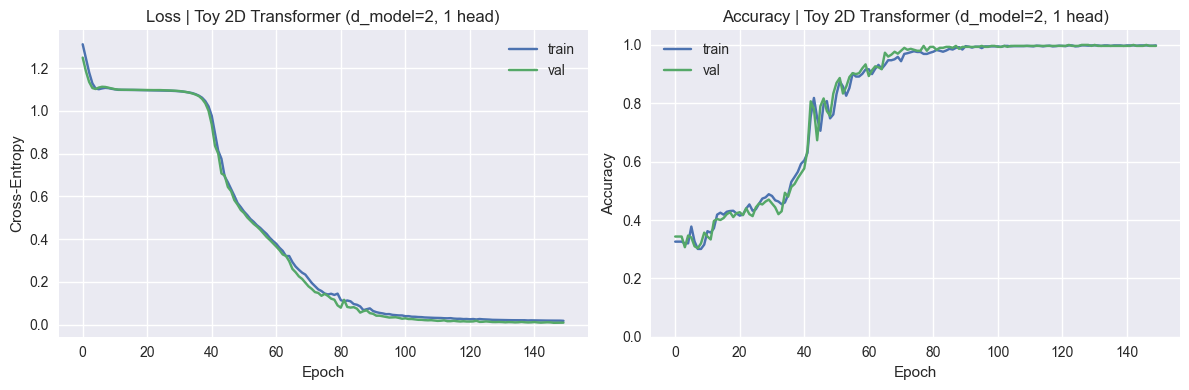

In [62]:
plot_history(toy_history, "Toy 2D Transformer (d_model=2, 1 head)")

toy_val_metrics = evaluate_classifier(toy_model, toy_val_loader, criterion, forward_fn=toy_forward)
print(f"Toy transformer validation accuracy: {toy_val_metrics['acc'] * 100:.1f}%")

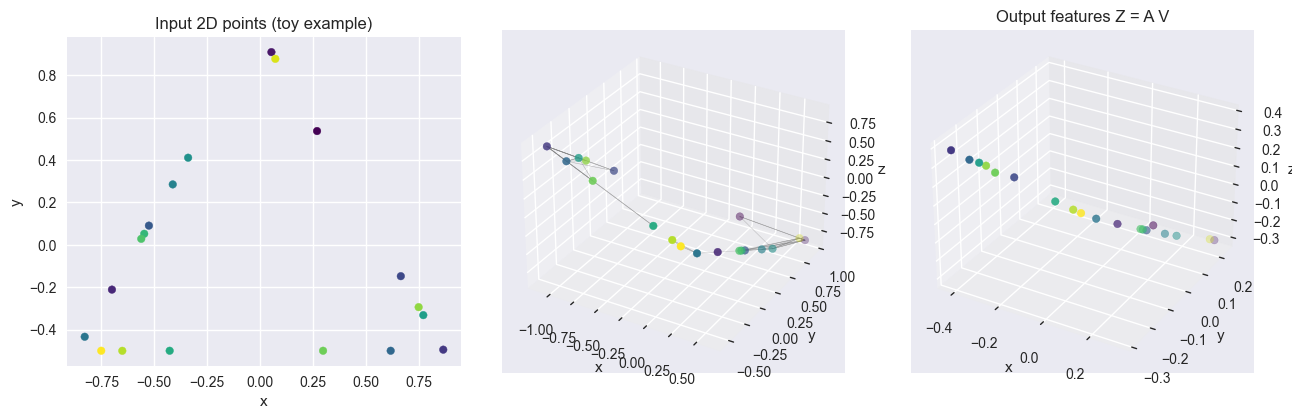

In [63]:
# Visualize one batch from the toy transformer with explicit Q, K, V, A, Z
toy_batch = next(iter(toy_val_loader))
toy_points = toy_batch["points"][0]  # (N, 2)
toy_mask = toy_batch["mask"][0]  # (N,)

# Restrict to valid (unpadded) points for clarity
valid_idx = (~toy_mask).nonzero(as_tuple=False).squeeze(-1)
toy_pts_np = toy_points[valid_idx].numpy()
toy_pts = toy_points[valid_idx]

mini_attn = MiniSelfAttention(input_dim=2, d_model=3)

# Initialize the mini attention block from the trained toy transformer:
# we reuse the input projection and the first layer's attention block.
with torch.no_grad():
    # Copy input projection (2x2 block is already the whole matrix)
    mini_attn.W_q.weight.copy_(toy_model.input_proj.weight)
    mini_attn.W_k.weight.copy_(toy_model.input_proj.weight)
    mini_attn.W_v.weight.copy_(toy_model.input_proj.weight)

mini_outputs = mini_attn(toy_pts)

Q = mini_outputs["Q"].detach().numpy()
K = mini_outputs["K"].detach().numpy()
V = mini_outputs["V"].detach().numpy()
A = mini_outputs["A"].detach().numpy()
Z = mini_outputs["Z"].detach().numpy()

fig, axes = plt.subplots(1, 3, figsize=(13, 4))

# Original points in input space
axes[0].scatter(toy_pts_np[:, 0], toy_pts_np[:, 1], c=np.arange(len(toy_pts_np)), cmap="viridis", s=30)
axes[0].set_title("Input 2D points (toy example)")
axes[0].set_aspect("equal")

# Latent/Q/K/Z plotting that adapts to 2D or 3D latent spaces and visualizes strong attention links.
d_latent = Q.shape[1]

if d_latent == 2:
    # Q and K in latent space (2D)
    axes[1].scatter(K[:, 0], K[:, 1], c="lightgray", s=20, label="K")
    axes[1].scatter(Q[:, 0], Q[:, 1], c=np.arange(len(Q)), cmap="viridis", s=25, marker="o", label="Q")
    axes[1].set_title("Latent space: Q and K (d_model=2)")
    axes[1].legend()
    axes[1].set_aspect("equal")

    # Visualize top-k attention links from each query to keys for clarity
    topk = 3
    for i in range(len(Q)):
        top_idxs = np.argsort(A[i])[-topk:]
        for j in top_idxs:
            # clamp alpha to valid matplotlib range [0, 1]
            alpha = max(0.0, min(1.0, float(A[i, j]) * 3.0))
            linewidth = max(0.5, float(A[i, j]) * 2.0)
            axes[1].plot([Q[i, 0], K[j, 0]], [Q[i, 1], K[j, 1]],
                         color="gray", alpha=alpha, linewidth=linewidth)

    # Z features in latent space (2D)
    axes[2].scatter(Z[:, 0], Z[:, 1], c=np.arange(len(Z)), cmap="viridis", s=30)
    axes[2].set_title("Output features Z = A V")
    axes[2].set_aspect("equal")

else:
    # d_latent == 3 -> replace the 2nd and 3rd Axes with 3D projections
    fig.delaxes(axes[1])
    fig.delaxes(axes[2])
    ax_kq = fig.add_subplot(1, 3, 2, projection="3d")
    ax_z = fig.add_subplot(1, 3, 3, projection="3d")
    axes[1] = ax_kq
    axes[1].set_title("Latent space: Q and K (d_model=3)")
    axes[2] = ax_z

    # Q and K in latent space (3D)
    ax_kq.scatter(K[:, 0], K[:, 1], K[:, 2], c="lightgray", s=20, label="K")
    sc = ax_kq.scatter(Q[:, 0], Q[:, 1], Q[:, 2], c=np.arange(len(Q)), cmap="viridis", s=30, label="Q")
    # Draw top-k attention links in 3D for each query
    topk = 3
    for i in range(len(Q)):
        top_idxs = np.argsort(A[i])[-topk:]
        for j in top_idxs:
            # clamp alpha to valid matplotlib range [0, 1]
            alpha = max(0.0, min(1.0, float(A[i, j]) * 3.0))
            linewidth = max(0.5, float(A[i, j]) * 2.0)
            ax_kq.plot([Q[i, 0], K[j, 0]], [Q[i, 1], K[j, 1]], [Q[i, 2], K[j, 2]],
                        color="gray", alpha=alpha, linewidth=linewidth)
        for j in top_idxs:
            ax_kq.plot([Q[i, 0], K[j, 0]], [Q[i, 1], K[j, 1]], [Q[i, 2], K[j, 2]],
                        color="gray", alpha=float(A[i, j])/np.max(A) * 1.0, linewidth=float(A[i, j]) * 2.0)

    # Z features in latent space (3D)
    ax_z.scatter(Z[:, 0], Z[:, 1], Z[:, 2], c=np.arange(len(Z)), cmap="viridis", s=30)
    ax_z.set_title("Output features Z = A V")

# tidy up legend/labels for readability
for ax in axes.flatten():
    if hasattr(ax, "set_xlabel"):
        ax.set_xlabel("x")
        ax.set_ylabel("y")
    if getattr(ax, "zaxis", None) is not None:
        ax.set_zlabel("z")



plt.tight_layout()


We can note a few things from this simple example:

- Even though the original points were shuffled in a random order (as you can see from the colors in the right plot above), we can see that the projected queries and keys (left plot) have learned to organize themselves in a meaningful way that almost mirrors the original x-y locations of the points.
- We can also see from the grey lines in the center plot that points attend most strongly to other points that are nearby in space, even though the model has no explicit knowledge of the spatial arrangement of the points.

Now let's pick a few example points and visualize how they attend to the rest of the set more directly by coloring the points according to the attention weights from a selected query point:

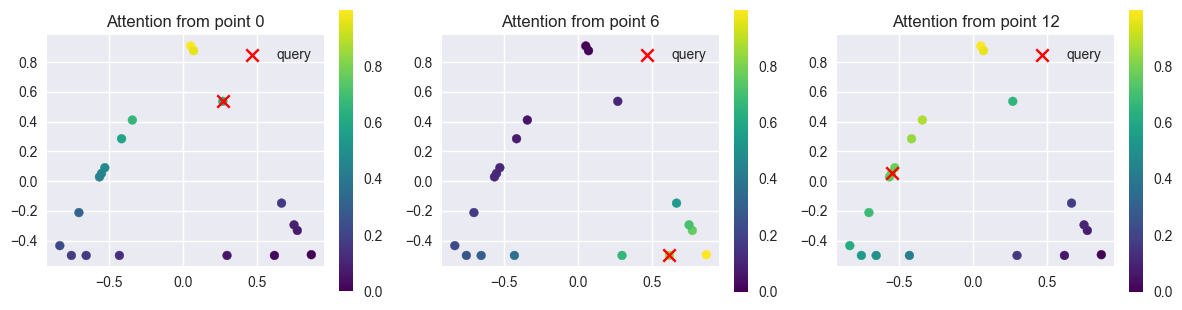

In [65]:
# Visualize attention weights for a few chosen query points (using the toy model)
def plot_attention_on_shape(points: np.ndarray, A: np.ndarray, query_indices: List[int]) -> None:
    """Overlay attention weights for selected queries on the 2D shape.

    For each query index i, we plot one panel where point j is colored by a_ij.
    """

    n_queries = len(query_indices)
    fig, axes = plt.subplots(1, n_queries, figsize=(4 * n_queries, 4))
    if n_queries == 1:
        axes = [axes]

    for ax, qi in zip(axes, query_indices):
        weights = A[qi]
        weights_norm = (weights - weights.min()) / (weights.max() - weights.min() + 1e-8)
        sc = ax.scatter(points[:, 0], points[:, 1], c=weights_norm, cmap="viridis", s=40)
        ax.scatter(points[qi, 0], points[qi, 1], c="red", s=80, marker="x", label="query")
        ax.set_title(f"Attention from point {qi}")
        ax.set_aspect("equal")
        ax.legend()
        plt.colorbar(sc, ax=ax, fraction=0.046)

    plt.tight_layout()

plot_attention_on_shape(toy_pts_np, A, query_indices=[0, max(1, len(toy_pts_np)//3), max(2, 2*len(toy_pts_np)//3)])

Here again we see that the attention weights are highest for points that are spatially close to the query point.

### Scaling up to a Full Transformer Encoder

The above example was a single-head, single-layer, low-dimension attention model, so that we could visualize everything in 2D and gain intuition. However, in practice, we want to use multiple layers, multiple heads, and higher-dimensional latent spaces to get good performance. Below we build a larger transformer model (labeled `SetTransformer`) that can be trained on the same 2D shapes dataset, but with more capacity.

In [ ]:
#| code-fold: false
class SetTransformer(nn.Module):
    def __init__(
        self,
        input_dim: int,
        num_classes: int,
        d_model: int = 64,
        n_heads: int = 4,
        num_layers: int = 3,
        dim_feedforward: int = 128,
        dropout: float = 0.1,
        pooling: str = "cls",
    ):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.layers = nn.ModuleList(
            [SelfAttentionBlock(d_model, n_heads, dim_feedforward, dropout) for _ in range(num_layers)]
        )
        self.pooling = pooling
        self.classifier = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, num_classes))

    def forward(
        self,
        x: torch.Tensor,
        src_key_padding_mask: Optional[torch.Tensor] = None,
        return_attention: bool = False,
        return_features: bool = False,
    ):
        batch_size = x.size(0)
        proj = self.input_proj(x)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        tokens = torch.cat([cls_tokens, proj], dim=1)

        if src_key_padding_mask is not None:
            pad = torch.zeros(src_key_padding_mask.size(0), 1, dtype=src_key_padding_mask.dtype, device=src_key_padding_mask.device)
            attn_mask = torch.cat([pad, src_key_padding_mask], dim=1)
        else:
            attn_mask = None

        attention_maps = []
        for layer in self.layers:
            tokens, attn = layer(tokens, key_padding_mask=attn_mask)
            attention_maps.append(attn)

        if self.pooling == "cls":
            features = tokens[:, 0]
        else:
            valid = (~attn_mask[:, 1:]).unsqueeze(-1) if attn_mask is not None else torch.ones_like(tokens[:, 1:])
            summed = (tokens[:, 1:] * valid).sum(dim=1)
            counts = valid.sum(dim=1).clamp_min(1.0)
            features = summed / counts

        logits = self.classifier(features)

        outputs = (logits,)
        if return_attention:
            outputs += (attention_maps,)
        if return_features:
            outputs += (features,)

        if len(outputs) == 1:
            return outputs[0]
        return outputs

Epoch 01/8 | train_loss=1.0918 train_acc=0.372 | val_loss=1.0390 val_acc=0.603
Epoch 02/8 | train_loss=0.7943 train_acc=0.677 | val_loss=0.3791 val_acc=0.914
Epoch 03/8 | train_loss=0.2146 train_acc=0.954 | val_loss=0.1356 val_acc=0.960
Epoch 04/8 | train_loss=0.0836 train_acc=0.980 | val_loss=0.0920 val_acc=0.968
Epoch 05/8 | train_loss=0.0446 train_acc=0.991 | val_loss=0.0378 val_acc=0.992
Epoch 06/8 | train_loss=0.0269 train_acc=0.995 | val_loss=0.0282 val_acc=0.995
Epoch 07/8 | train_loss=0.0225 train_acc=0.996 | val_loss=0.0248 val_acc=0.995
Epoch 08/8 | train_loss=0.0196 train_acc=0.996 | val_loss=0.0249 val_acc=0.993
Noise 0.01 | Transformer accuracy: 99.3%
Epoch 01/8 | train_loss=1.0979 train_acc=0.353 | val_loss=1.0361 val_acc=0.424
Epoch 02/8 | train_loss=0.8103 train_acc=0.699 | val_loss=0.4268 val_acc=0.898
Epoch 03/8 | train_loss=0.2339 train_acc=0.953 | val_loss=0.0956 val_acc=0.989
Epoch 04/8 | train_loss=0.0703 train_acc=0.987 | val_loss=0.0427 val_acc=0.994
Epoch 05/8 

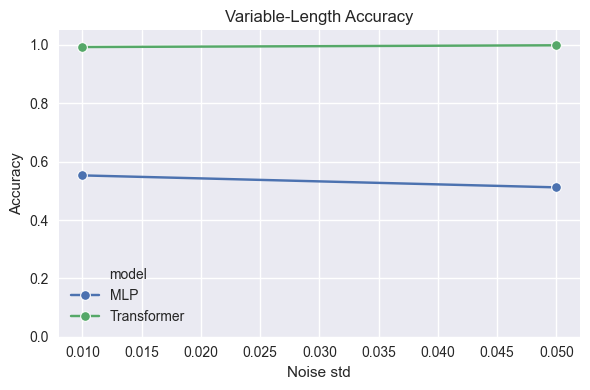

In [67]:
transformer_results = []
transformer_histories = {}

for noise in noise_levels:
    dataset = VariableShapeDataset(num_samples=5000, length_range=(20, 200), noise_std=noise)
    collate_fn = build_variable_collate(dataset.max_points, feature_dim=2)
    train_ds, val_ds = random_split(
        dataset,
        [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))],
    )
    train_loader = DataLoader(train_ds, batch_size=192, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_ds, batch_size=256, shuffle=False, collate_fn=collate_fn)

    transformer = SetTransformer(input_dim=2, num_classes=len(SHAPE_TYPES), d_model=96, n_heads=4, num_layers=4)
    optimizer = torch.optim.AdamW(transformer.parameters(), lr=2e-4, weight_decay=1e-4)

    def transformer_forward(model, batch, device):
        return model(batch["points"].to(device), src_key_padding_mask=batch["mask"].to(device))

    history = train_classifier(
        transformer,
        train_loader,
        optimizer,
        criterion,
        epochs=8,
        forward_fn=transformer_forward,
        val_loader=val_loader,
    )
    transformer_histories[noise] = history
    metrics = evaluate_classifier(transformer, val_loader, criterion, forward_fn=transformer_forward)
    transformer_results.append({"model": "Transformer", "noise": noise, "accuracy": metrics["acc"]})
    print(f"Noise {noise:.2f} | Transformer accuracy: {metrics['acc'] * 100:.1f}%")

combined_df = pd.concat([mlp_variable_df, pd.DataFrame(transformer_results)])
plot_metric_curve(combined_df, "Variable-Length Accuracy", hue="model")

We can also visualize the attention patterns learned by this larger model, as well as how the MLP is weighting points after pooling:

In [68]:
sample_noise = noise_levels[1]
dataset = VariableShapeDataset(num_samples=600, length_range=(20, 200), noise_std=sample_noise)
collate_fn = build_variable_collate(dataset.max_points, feature_dim=2)
loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

transformer_demo = SetTransformer(input_dim=2, num_classes=len(SHAPE_TYPES), d_model=96, n_heads=4, num_layers=4)
optimizer = torch.optim.AdamW(transformer_demo.parameters(), lr=2e-4)


def transformer_forward(model, batch, device):
    return model(batch["points"].to(device), src_key_padding_mask=batch["mask"].to(device))


_ = train_classifier(
    transformer_demo,
    loader,
    optimizer,
    criterion,
    epochs=50,
    forward_fn=transformer_forward,
)


Epoch 01/50 | train_loss=1.1410 train_acc=0.347
Epoch 02/50 | train_loss=1.0896 train_acc=0.365
Epoch 03/50 | train_loss=0.9695 train_acc=0.532
Epoch 04/50 | train_loss=0.5630 train_acc=0.798
Epoch 05/50 | train_loss=0.2649 train_acc=0.935
Epoch 06/50 | train_loss=0.1571 train_acc=0.957
Epoch 07/50 | train_loss=0.1191 train_acc=0.960
Epoch 08/50 | train_loss=0.0893 train_acc=0.968
Epoch 09/50 | train_loss=0.0819 train_acc=0.973
Epoch 10/50 | train_loss=0.0574 train_acc=0.982
Epoch 11/50 | train_loss=0.0449 train_acc=0.983
Epoch 12/50 | train_loss=0.0529 train_acc=0.983
Epoch 13/50 | train_loss=0.0480 train_acc=0.983
Epoch 14/50 | train_loss=0.0382 train_acc=0.990
Epoch 15/50 | train_loss=0.0329 train_acc=0.990
Epoch 16/50 | train_loss=0.0468 train_acc=0.983
Epoch 17/50 | train_loss=0.0371 train_acc=0.985
Epoch 18/50 | train_loss=0.0409 train_acc=0.985
Epoch 19/50 | train_loss=0.0172 train_acc=0.995
Epoch 20/50 | train_loss=0.0347 train_acc=0.987
Epoch 21/50 | train_loss=0.0125 train_ac

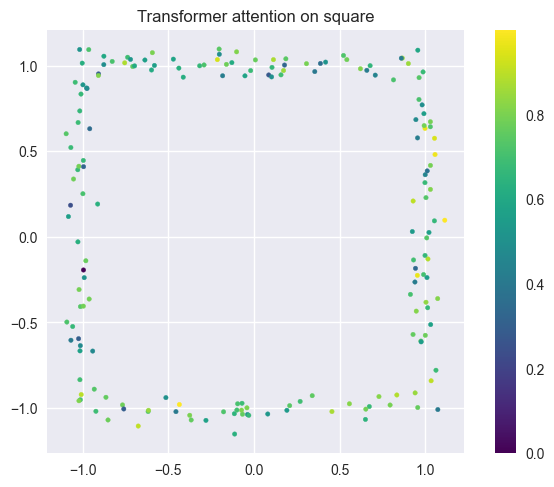

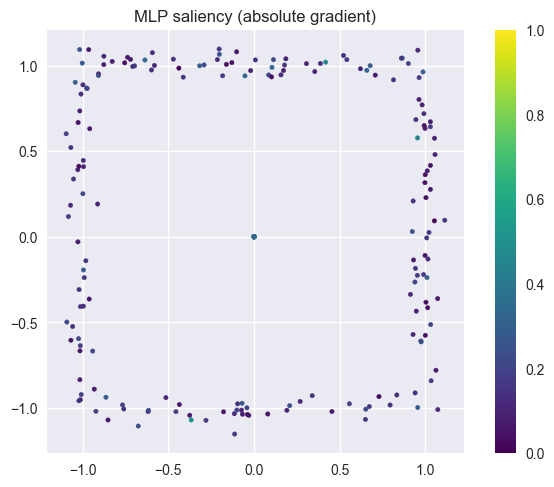

In [34]:

batch = next(iter(loader))
points = batch["points"][0:1]
mask = batch["mask"][0:1]
label = batch["labels"][0].item()
logits, attn_maps, _ = transformer_demo(
    points.to(DEVICE),
    src_key_padding_mask=mask.to(DEVICE),
    return_attention=True,
    return_features=True,
)
# attn_maps is a list of attention tensors with shape (B, T, T).
# We want the attention from the CLS token (index 0) to the actual points (indices 1:).
# For a batch size of 1, select attn_maps[-1][0, 0, 1:].
attn_cls = attn_maps[-1][0, 0, 1:].detach().cpu().numpy()
valid_points = points[0][~mask[0]].numpy()
attn_cls = attn_cls[: valid_points.shape[0]]
plt.figure()
plot_attention_overlay(valid_points, attn_cls, f"Transformer attention on {SHAPE_TYPES[label]}")
plt.show()
# Use the MLP that matches the flattened variable-length input (mlp has input_dim = dataset.max_points * 2)
# Move the tensor to device first, then detach and enable grad so the tensor is a leaf (avoids grad being None).
flat_sample = batch["inputs"][0:1].to(DEVICE).clone().detach().requires_grad_(True)

# Ensure the correct MLP (trained for variable-sized inputs) is used and moved to device
mlp = mlp.to(DEVICE)
mlp.zero_grad()

logits = mlp(flat_sample)
score = logits[0, label]
score.backward()

# Now flat_sample.grad will be populated (it's a leaf tensor). Compute per-point saliency.
with torch.no_grad():
    grads = flat_sample.grad.view(-1, 2).norm(dim=-1).cpu().numpy()
    base_points = batch["points"][0].numpy()
plt.figure()
plot_attention_overlay(base_points[: grads.shape[0]], grads, "MLP saliency (absolute gradient)")
plt.show()

## 3D Shapes — Synthetic Point Clouds

In the above examples, we showed a simple 2D shape classification task to build intuition about how transformers work on sets of points. However, the technique is more broadly applicable. than this and can be used for more complex problems where something like a 2D or 3D Convolutional Neural Network (CNN) would not be appropriate. In engineering a common task is dealing with point clouds or meshes, and these can often be un-ordered and of variable size, just like in the above case. 

We will demonstrate this on a simple 3D shape classification task using synthetic point clouds. We will vary the density, jitter, and rotations, and also compare Transformers to point-cloud specific architectures like PointNet.

### PointNet vs. Transformer for Point Clouds



Before training the 3D models, it is helpful to review the [**PointNet**](https://arxiv.org/abs/1612.00593) architecture, since it is the "convolutional cousin" of our set transformer, and will also act as a stronger baseline comparison than the MLP we used above.

#### PointNet

Specifically, given a set of 3D points $X = \{p_1, \dots, p_n\}$ with $p_i \in \mathbb{R}^3$, PointNet applies a **shared MLP** to every point and then aggregates with a symmetric pooling function:

\begin{align}

h_i &= g(p_i; \theta) \in \mathbb{R}^m, \\

H &= [h_1, \dots, h_n] \in \mathbb{R}^{m \times n}, \\

z &= \text{pool}(H) = \max_i h_i \quad (\text{or mean}), \\

y &= f(z; \phi).

\end{align}

Here $g$ and $f$ are small MLPs, and $m$ is the dimension of our model's latent space, which we get to choose. In our implementation:

- $g$ is the 1D-convolutional `shared_mlp` (kernel size 1 = pointwise MLP),

- `torch.max` over points implements the permutation-invariant pooling, and

- `fc` maps the global feature $z$ to class logits.



**Key idea:** permutation invariance is enforced _only_ by the final pooling. Every point is processed independently before pooling, so there is **no explicit message passing between points**.



#### Transformer for point clouds



The set transformer uses almost the opposite design:

- Each point is first embedded into a latent space $h_i = W x_i$.

- Self-attention layers repeatedly **mix information across points** via learned attention weights $a_{ij}$.

- A CLS token or pooling over attended features produces the final global descriptor.



From a functional perspective:

- PointNet learns $y = F\left( \max_i g(p_i) \right)$, where all interactions are implicit through the max.

- The transformer learns $y = F_\text{Trans}(\{p_1, \dots, p_n\})$ where each layer already blends local and global structure through attention.



In practice, this means that PointNet is very strong for **coarse global shape** (e.g., sphere vs. cube) but may struggle to capture fine-grained relational patterns unless we widen $g$ a lot. Transformers can model those relations directly, at the cost of more computation.


What we will do now is construct a dataset of 3D point clouds sampled from simple shapes (spheres, cubes, cones, cylinders), and then train both a PointNet and a Transformer model on this dataset to compare their performance. Let's first take a look at some example data samples from our synthetic 3D shapes dataset:

In [79]:
SHAPE_TYPES_3D = ["sphere", "cube", "cylinder", "pyramid"]


def random_rotation_matrix() -> np.ndarray:
    angles = np.random.uniform(0, 2 * np.pi, size=3)
    cx, cy, cz = np.cos(angles)
    sx, sy, sz = np.sin(angles)
    rot_x = np.array([[1, 0, 0], [0, cx, -sx], [0, sx, cx]])
    rot_y = np.array([[cy, 0, sy], [0, 1, 0], [-sy, 0, cy]])
    rot_z = np.array([[cz, -sz, 0], [sz, cz, 0], [0, 0, 1]])
    return rot_z @ rot_y @ rot_x


def generate_3d_shape(shape_type: str, n_points: int, noise_std: float = 0.01) -> np.ndarray:
    """Generate 3D shape point cloud with exactly n_points.

    Fixes previous cube face broadcasting issue by using scalar axis assignment
    with per-face coordinate sampling. Adds safety to enforce exact length.
    """
    if shape_type not in SHAPE_TYPES_3D:
        raise ValueError(shape_type)

    if shape_type == "sphere":
        phi = np.random.uniform(0, 2 * np.pi, size=n_points)
        costheta = np.random.uniform(-1, 1, size=n_points)
        theta = np.arccos(costheta)
        x = np.sin(theta) * np.cos(phi)
        y = np.sin(theta) * np.sin(phi)
        z = np.cos(theta)
        points = np.stack([x, y, z], axis=1)

    elif shape_type == "cube":
        # Choose a face for each point: 0:+x,1:-x,2:+y,3:-y,4:+z,5:-z
        faces = np.random.choice(6, size=n_points)
        # For each point we need two free coordinates in [-1,1]
        free = np.random.uniform(-1, 1, size=(n_points, 2))
        points = np.zeros((n_points, 3))
        for face in range(6):
            mask = faces == face
            if not mask.any():
                continue
            m = mask.sum()
            if face == 0:  # +x face
                points[mask, 0] = 1.0
                points[mask, 1] = free[mask, 0]
                points[mask, 2] = free[mask, 1]
            elif face == 1:  # -x face
                points[mask, 0] = -1.0
                points[mask, 1] = free[mask, 0]
                points[mask, 2] = free[mask, 1]
            elif face == 2:  # +y face
                points[mask, 1] = 1.0
                points[mask, 0] = free[mask, 0]
                points[mask, 2] = free[mask, 1]
            elif face == 3:  # -y face
                points[mask, 1] = -1.0
                points[mask, 0] = free[mask, 0]
                points[mask, 2] = free[mask, 1]
            elif face == 4:  # +z face
                points[mask, 2] = 1.0
                points[mask, 0] = free[mask, 0]
                points[mask, 1] = free[mask, 1]
            elif face == 5:  # -z face
                points[mask, 2] = -1.0
                points[mask, 0] = free[mask, 0]
                points[mask, 1] = free[mask, 1]

    elif shape_type == "cylinder":
        angles = np.random.uniform(0, 2 * np.pi, size=n_points)
        heights = np.random.uniform(-1, 1, size=n_points)
        x = np.cos(angles)
        y = np.sin(angles)
        z = heights
        points = np.stack([x, y, z], axis=1)

    else:  # hollow pyramid with points sampled on each side
        # Define pyramid vertices: apex at (0, 0, 1), square base at z = -1
        apex = np.array([0.0, 0.0, 1.0])
        base_vertices = np.array([
            [1.0, 1.0, -1.0],
            [-1.0, 1.0, -1.0],
            [-1.0, -1.0, -1.0],
            [1.0, -1.0, -1.0]
        ])
        
        # Distribute points across 4 triangular side faces + square base
        n_faces = 5
        base_count = n_points // n_faces
        rem = n_points % n_faces
        counts = [base_count + (i < rem) for i in range(n_faces)]
        
        face_points = []
        
        # Sample points on each triangular side face (apex to two base corners)
        for i in range(4):
            n_face = counts[i]
            if n_face == 0:
                continue
            v1 = base_vertices[i]
            v2 = base_vertices[(i + 1) % 4]
            # Barycentric coordinates for triangle (apex, v1, v2)
            u = np.random.uniform(0, 1, size=n_face)
            v = np.random.uniform(0, 1, size=n_face)
            # Fold triangle: if u + v > 1, reflect to other half
            mask = (u + v) > 1
            u[mask] = 1 - u[mask]
            v[mask] = 1 - v[mask]
            w = 1 - u - v
            pts = (w[:, None] * apex + 
                u[:, None] * v1 + 
                v[:, None] * v2)
            face_points.append(pts)
        
        # Sample points uniformly on the square base face
        n_base = counts[4]
        if n_base > 0:
            # Uniform sampling on the square at z = -1, x in [-1, 1], y in [-1, 1]
            base_x = np.random.uniform(-1, 1, size=n_base)
            base_y = np.random.uniform(-1, 1, size=n_base)
            base_z = np.full(n_base, -1.0)
            base_pts = np.stack([base_x, base_y, base_z], axis=1)
            face_points.append(base_pts)
        
        points = np.concatenate(face_points, axis=0) if face_points else np.zeros((0, 3))
        

    # Add noise and random rotation
    points += np.random.normal(scale=noise_std, size=points.shape)
    points = points @ random_rotation_matrix().T

    # Safety: enforce exact length (already ensured but keep consistency with 2D generator)
    if points.shape[0] != n_points:
        if points.shape[0] > n_points:
            points = points[:n_points]
        else:
            extra_idx = np.random.choice(points.shape[0], n_points - points.shape[0], replace=True)
            points = np.concatenate([points, points[extra_idx]], axis=0)
    return points


class SyntheticPointCloudDataset(Dataset):
    def __init__(self, num_samples: int = 3000, length_range: Tuple[int, int] = (200, 1000), noise_std: float = 0.02):
        self.samples: List[torch.Tensor] = []
        self.labels: List[int] = []
        self.max_points = length_range[1]
        for _ in range(num_samples):
            label = random.randrange(len(SHAPE_TYPES_3D))
            n_points = random.randint(*length_range)
            pts = generate_3d_shape(SHAPE_TYPES_3D[label], n_points=n_points, noise_std=noise_std)
            self.samples.append(torch.tensor(pts, dtype=torch.float32))
            self.labels.append(label)

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        return {"points": self.samples[idx], "labels": torch.tensor(self.labels[idx], dtype=torch.long)}


def build_pointcloud_collate(max_points: int, dims: int = 3):
    def collate(batch: List[Dict[str, torch.Tensor]]) -> Dict[str, torch.Tensor]:
        batch_size = len(batch)
        padded = torch.zeros(batch_size, max_points, dims)
        mask = torch.ones(batch_size, max_points, dtype=torch.bool)
        labels = torch.zeros(batch_size, dtype=torch.long)
        for i, item in enumerate(batch):
            pts = item["points"]
            n = min(pts.size(0), max_points)
            padded[i, :n] = pts[:n]
            mask[i, :n] = False
            labels[i] = item["labels"]
        flat = padded.reshape(batch_size, -1)
        return {"points": padded, "mask": mask, "inputs": flat, "labels": labels}

    return collate

In [83]:
cloud_dataset = SyntheticPointCloudDataset(num_samples=3200, length_range=(256, 1024), noise_std=0.002)
collate_cloud = build_pointcloud_collate(cloud_dataset.max_points, dims=3)
train_cloud, val_cloud = random_split(
    cloud_dataset,
    [int(0.75 * len(cloud_dataset)), len(cloud_dataset) - int(0.75 * len(cloud_dataset))],
)
train_loader_cloud = DataLoader(train_cloud, batch_size=64, shuffle=True, collate_fn=collate_cloud)
val_loader_cloud = DataLoader(val_cloud, batch_size=128, shuffle=False, collate_fn=collate_cloud)

# Interactive demo (set interactive=True)
for idx in np.random.choice(len(cloud_dataset), size=3, replace=False):
    pts = cloud_dataset[idx]["points"].numpy()
    label = SHAPE_TYPES_3D[cloud_dataset.labels[idx]]
    scatter_3d_points(pts, f"Example {label}", interactive=True)

In [ ]:
#| code-fold: false
class PointNetClassifier(nn.Module):
    def __init__(self, input_dim: int = 3, widths: Tuple[int, ...] = (64, 128, 256), num_classes: int = 4, dropout: float = 0.3):
        super().__init__()
        layers: List[nn.Module] = []
        dims = [input_dim, *widths]
        for in_dim, out_dim in zip(dims[:-1], dims[1:]):
            layers.append(nn.Conv1d(in_dim, out_dim, kernel_size=1))
            layers.append(nn.BatchNorm1d(out_dim))
            layers.append(nn.ReLU())
        self.shared_mlp = nn.Sequential(*layers)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Sequential(
            nn.Linear(widths[-1], 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes),
        )

    def forward(self, x: torch.Tensor, return_features: bool = False):
        x = x.transpose(1, 2)
        features = self.shared_mlp(x)
        pooled = torch.max(features, dim=2).values
        logits = self.fc(self.dropout(pooled))
        if return_features:
            return logits, pooled
        return logits

In [ ]:
#| code-fold: false
mlp_cloud = ShapeMLP(input_dim=cloud_dataset.max_points * 3, hidden_dims=(16, 16, 16), num_classes=len(SHAPE_TYPES_3D))
pointnet = PointNetClassifier(num_classes=len(SHAPE_TYPES_3D), widths = (16, 16, 16))
transformer_cloud = SetTransformer(
    input_dim=3,
    num_classes=len(SHAPE_TYPES_3D),
    d_model= 15,
    n_heads=2,
    num_layers=3,
    dim_feedforward=20,
)


def pointnet_forward(model, batch, device):
    return model(batch["points"].to(device))


def transformer_cloud_forward(model, batch, device):
    return model(batch["points"].to(device), src_key_padding_mask=batch["mask"].to(device))


models_cloud = {
    "MLP": (mlp_cloud, mlp_forward),
    "PointNet": (pointnet, pointnet_forward),
    "Transformer": (transformer_cloud, transformer_cloud_forward),
}

# Print the parameter counts for each of the models in models_cloud:
for name, (model, _) in models_cloud.items():
    param_count = sum(p.numel() for p in model.parameters())
    print(f"{name} parameter count: {param_count:,}")


MLP parameter count: 49,780
PointNet parameter count: 6,084
Transformer parameter count: 4,099


In [108]:

cloud_histories = {}
cloud_metrics = []

for name, (model, forward_fn) in models_cloud.items():
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4 if name != "Transformer" else 3e-3, weight_decay=1e-4)
    history = train_classifier(
        model,
        train_loader_cloud,
        optimizer,
        criterion,
        epochs=15,
        forward_fn=forward_fn,
        val_loader=val_loader_cloud,
    )
    cloud_histories[name] = history
    metrics = evaluate_classifier(model, val_loader_cloud, criterion, forward_fn=forward_fn)
    cloud_metrics.append({"model": name, "accuracy": metrics["acc"]})
    print(f"{name} accuracy: {metrics['acc'] * 100:.1f}%")


Epoch 01/15 | train_loss=1.3906 train_acc=0.250 | val_loss=1.3825 val_acc=0.275
Epoch 02/15 | train_loss=1.3708 train_acc=0.310 | val_loss=1.3693 val_acc=0.261
Epoch 02/15 | train_loss=1.3708 train_acc=0.310 | val_loss=1.3693 val_acc=0.261
Epoch 03/15 | train_loss=1.3203 train_acc=0.353 | val_loss=1.3281 val_acc=0.306
Epoch 03/15 | train_loss=1.3203 train_acc=0.353 | val_loss=1.3281 val_acc=0.306
Epoch 04/15 | train_loss=1.2075 train_acc=0.451 | val_loss=1.2738 val_acc=0.405
Epoch 04/15 | train_loss=1.2075 train_acc=0.451 | val_loss=1.2738 val_acc=0.405
Epoch 05/15 | train_loss=1.0446 train_acc=0.561 | val_loss=1.2201 val_acc=0.410
Epoch 05/15 | train_loss=1.0446 train_acc=0.561 | val_loss=1.2201 val_acc=0.410
Epoch 06/15 | train_loss=0.8864 train_acc=0.594 | val_loss=1.2035 val_acc=0.414
Epoch 06/15 | train_loss=0.8864 train_acc=0.594 | val_loss=1.2035 val_acc=0.414
Epoch 07/15 | train_loss=0.7685 train_acc=0.644 | val_loss=1.2120 val_acc=0.410
Epoch 07/15 | train_loss=0.7685 train_ac

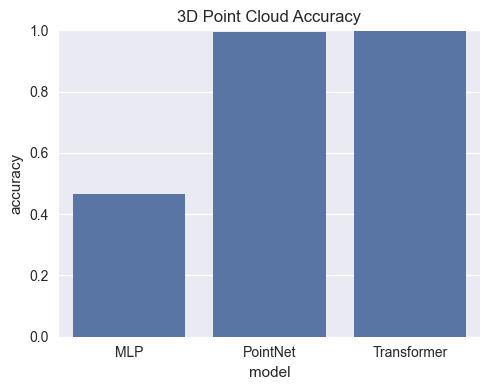

In [109]:

cloud_metrics_df = pd.DataFrame(cloud_metrics)
plt.figure(figsize=(5, 4))
sns.barplot(data=cloud_metrics_df, x="model", y="accuracy")
plt.ylim(0, 1)
plt.title("3D Point Cloud Accuracy")
plt.tight_layout()

In [110]:
transformer_ref = models_cloud["Transformer"][0]
embeddings = []
labels = []
with torch.no_grad():
    for batch in val_loader_cloud:
        logits, features = transformer_ref(
            batch["points"].to(DEVICE),
            src_key_padding_mask=batch["mask"].to(DEVICE),
            return_features=True,
        )
        embeddings.append(features.cpu())
        labels.append(batch["labels"])
embeddings = torch.cat(embeddings).numpy()
labels = torch.cat(labels).numpy()
visualize_embeddings(embeddings, labels, SHAPE_TYPES_3D, "Transformer embeddings", method="pca", dim=3)

batch = next(iter(val_loader_cloud))
logits, attn_maps, _ = transformer_ref(
    batch["points"].to(DEVICE),
    src_key_padding_mask=batch["mask"].to(DEVICE),
    return_attention=True,
    return_features=True,
)
batch_idx = 6  # Visualize this sample in batch
# attn_maps[-1] has shape (B, N, N) where N includes the CLS token
# We want attention from CLS token (index 0) to actual points (indices 1:)
attn_cls = attn_maps[-1][batch_idx, 0, 1:].detach().cpu().numpy()
mask = batch["mask"][batch_idx].numpy()
valid_points = batch["points"][batch_idx][~mask].numpy()
attn_cls = attn_cls[: valid_points.shape[0]]
scatter_3d_points(valid_points, f"Attention heatmap ({SHAPE_TYPES_3D[batch['labels'][batch_idx].item()]})", colors=attn_cls, interactive=True)

## Summary

In this chapter we introduced the concept of transformers, which use self-attention to decide which elements in an un-ordered set to use for downstream prediction tasks. While these were developed in the context of Natural Language Processing (where the un-ordered set consisted of characters, words, or phrases), we saw in this notebook how it could extend to arbitrary other objects like unordered point-cloud data. What we saw in our comparative experiments were:

- **MLP (flattened inputs)**
  - *Strengths:* simple to implement; fast on small, fixed-size inputs; works well when point order and count are strictly controlled (our first 2D experiment).
  - *Weaknesses:* not permutation-invariant; brittle under reordering, variable-length sets, and padding artifacts; has no built-in sense of locality or geometry beyond what you manually encode in the features.

- **PointNet (shared MLP + symmetric pooling)**
  - *Strengths:* explicitly permutation-invariant via max/mean pooling; handles variable point counts; very effective for coarse global 3D shape classification with relatively few parameters.
  - *Weaknesses:* points do not interact before pooling, so capturing subtle **relations** (e.g., "distance between two features" or "joint configuration of surfaces") may require very wide hidden layers; global pooling can throw away spatial structure that might matter for fine-grained tasks.

- **Set Transformer (self-attention on points)**
  - *Strengths:* every point can attend to every other, so the model naturally captures edges, corners, support planes, and long-range geometric relations; masking and pooling make it robust to variable-length, noisy, and unordered sets; the same architecture scales from toy 2D sets to realistic 3D scans.
  - *Weaknesses:* attention is more computationally expensive than pointwise MLPs (roughly $\mathcal{O}(n^2)$ in the number of points per set); requires more care in tuning depth, width, and regularization.
